## Import

In [11]:
from datetime import datetime
import pandas as pd
import random
import os
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

def norm(df):
    df_normalized = (df - df.mean()) / df.std()+1e-7
    df_normalized.head()
    df_normalized.dropna(axis=1)
    return df_normalized
    

## Data Load

In [4]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [5]:
train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
train_y = train_df['Y_Class']

test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])

## Data Pre-processing

In [6]:
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

array([ 0., 10., 11.])

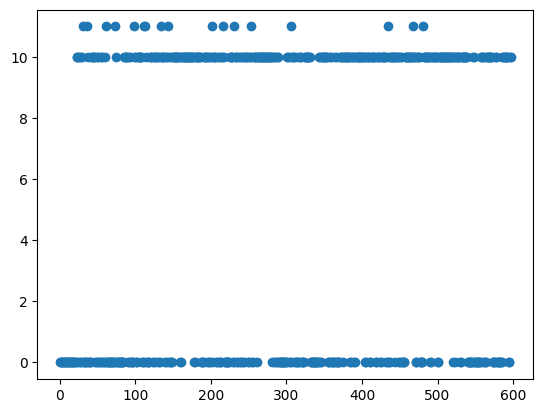

In [13]:
plt.scatter(range(len(train_x.X_8)), train_x['X_8'])
train_x['X_8'].unique()


In [7]:
# X_ range 1 ~ 2875
drop_list = []
for i in range(1,2876):
    col = f'X_{i}'
    if len(train_x[col].unique()) == 1:
        drop_list.append(col)
len(drop_list)

281

In [8]:
train_x = train_x.drop(columns=drop_list)
test_x = test_x.drop(columns=drop_list)
train_x.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,X_9,X_10,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,0.0
1,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,0.0
2,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35,0.0
3,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,165.8,384.0,369.188679,353.0,37.74,39.17,52.17,30.58,71.78,0.0
4,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97,0.0


In [9]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 
print('Done.')

Done.


## Classification Model Fit

In [31]:
val_split = False
val_size = 0.1
if val_split:
    t_len = int((1-val_size)*len(train_x))
    val_x = train_x[t_len:]
    val_y = train_y[t_len:]
    train_x = train_x[:t_len]
    train_y = train_y[:t_len]
RF = CatBoostClassifier(random_state=37,learning_rate=0.03,iterations=2000,eval_metric='Accuracy')
RF.fit(train_x, train_y,cat_features=[0,1,9],use_best_model=True,eval_set=(val_x,val_y))
print('Done.')

0:	learn: 0.7509294	test: 0.4500000	best: 0.4500000 (0)	total: 221ms	remaining: 7m 22s
1:	learn: 0.7639405	test: 0.4166667	best: 0.4500000 (0)	total: 420ms	remaining: 6m 59s
2:	learn: 0.7565056	test: 0.3833333	best: 0.4500000 (0)	total: 643ms	remaining: 7m 7s
3:	learn: 0.7490706	test: 0.4833333	best: 0.4833333 (3)	total: 838ms	remaining: 6m 58s
4:	learn: 0.7509294	test: 0.4833333	best: 0.4833333 (3)	total: 1.02s	remaining: 6m 48s
5:	learn: 0.7472119	test: 0.4833333	best: 0.4833333 (3)	total: 1.19s	remaining: 6m 36s
6:	learn: 0.7453532	test: 0.4833333	best: 0.4833333 (3)	total: 1.37s	remaining: 6m 29s
7:	learn: 0.7416357	test: 0.4666667	best: 0.4833333 (3)	total: 1.55s	remaining: 6m 25s
8:	learn: 0.7434944	test: 0.4666667	best: 0.4833333 (3)	total: 1.72s	remaining: 6m 21s
9:	learn: 0.7434944	test: 0.4666667	best: 0.4833333 (3)	total: 1.91s	remaining: 6m 19s
10:	learn: 0.7453532	test: 0.4666667	best: 0.4833333 (3)	total: 2.1s	remaining: 6m 19s
11:	learn: 0.7453532	test: 0.4666667	best: 0

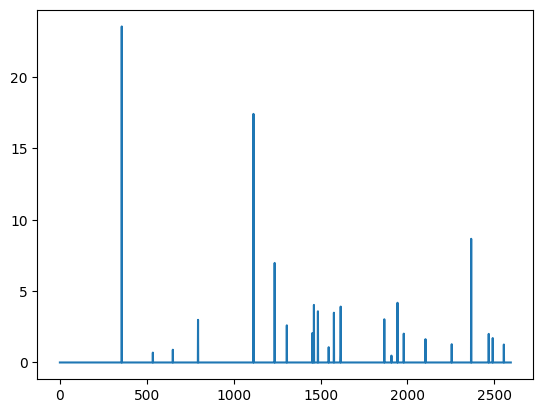

In [32]:

plt.plot(RF.get_feature_importance())
plt.show()

In [33]:
np.where(RF.get_feature_importance()>1.0)

(array([ 356,  795, 1114, 1236, 1306, 1453, 1462, 1485, 1547, 1577, 1616,
        1867, 1943, 1979, 2104, 2255, 2367, 2468, 2491, 2555], dtype=int64),)

## Inference

In [34]:
preds = RF.predict(test_x)
print('Done.')

Done.


In [35]:
for i in range(3):
    print(len(preds[preds ==i]))

# 0.71
# 38
# 264
# 8

3
307
0


## Submit

In [30]:
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M")
os.makedirs('./result',exist_ok=True)
submit = pd.read_csv('./sample_submission.csv')
submit['Y_Class'] = preds
submit.to_csv(f'./result/baseline_submission_{formatted_datetime}.csv', index=False)